# **Test Ground for EWC Calculations**

## **Import libraries**

In [1]:
from copy import deepcopy

import torch
import torch.nn as nn
import torch.autograd as autograd

import numpy as np
import matplotlib.pyplot as plt

from dcgan.components.generator import Generator
from dcgan.components.discriminator import Discriminator

## **Define class and functions**

In [7]:
class EWC:
    """
    Class for performing Elastic Weight Consolidation
    Reference link:
        https://discuss.pytorch.org/t/implementation-of-elastic-weight-consolidation-fisher-information-matrix/9309/3 
    """

    def __init__(self, model_anchor):
        self._model_anchor = model_anchor
        self._params_anchor = {n: p for n, p in model_anchor.named_parameters()}
        self._fishers, self._mean_fishers = None, None


    def _calc_fisher(self, likelihood, nsample=1):
        grads = autograd.grad(likelihood, self._model_anchor.parameters())
        _fishers = [(g**2)/nsample for g in grads]

        param_names = [name for name, _ in self._model_anchor.named_parameters()]
        fs_dict = {n: f for n, f in zip(param_names, _fishers)}

        return fs_dict
    

    def set_fisher(self, likelihood, nsample=1):
        self._fishers = self._calc_fisher(likelihood, nsample=nsample)


    def get_fisher(self): return self._fishers

    
    def calc_ewc(self, model, weight=5e8):
        params = {n: p for n, p in model.named_parameters()}

        ewc = 0
        for name in self._fishers:
            _ewc = self._fishers[name]*(params[name] - self._params_anchor[name])**2
            ewc += _ewc.sum()

        return weight*ewc


# def fisher(model, likelihood, nsample=1):
#     """
#     Funny ref link:
#     https://discuss.pytorch.org/t/implementation-of-elastic-weight-consolidation-fisher-information-matrix/9309/3 
#     """

#     grads = autograd.grad(likelihood, model.parameters())
#     fs = []
#     for g in grads:
#         fs.append((g**2).sum()/nsample) 

#     param_names = [name for name, _ in model.named_parameters()]
#     fs_dict = {n: f.item() for n, f in zip(param_names, fs)}

#     return fs_dict


def loss_adapt(l_adv, ewc, model, weight=5e8):
    l_ewc = ewc.calc_ewc(model, weight=weight)
    return l_adv + l_ewc

## **Model configuration**

In [3]:
gen_model = Generator()
gen_model.load_state_dict(torch.load('models/epoch145_gen.pth'))

dis_model = Discriminator()
dis_model.load_state_dict(torch.load('models/epoch145_dis.pth'))

<All keys matched successfully>

## **Set hyperparameters**

In [4]:
batch_size = 256
latent_size = 512
regWeight = 10
criterion = nn.BCELoss()

## **Usage demo**

tensor(5.5293, grad_fn=<BinaryCrossEntropyBackward0>)


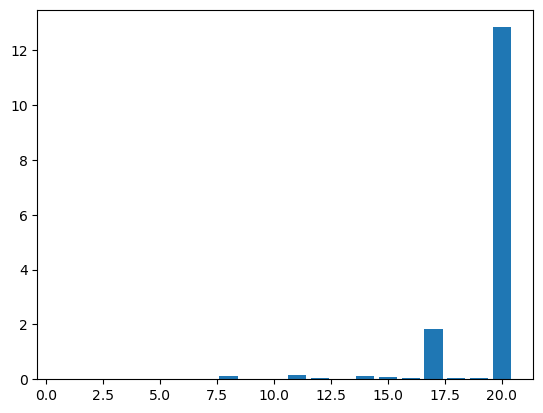

In [8]:
ewc = EWC(gen_model)

# Generate sample input and output
noise = torch.randn(batch_size, latent_size)
output_d = dis_model(gen_model(noise)).view(-1)
real_label = torch.full((batch_size, ), 1, dtype=torch.float)

# Error between Discriminator output and actual label
likelihood = criterion(output_d, real_label)
print(likelihood)

# Compute Fisher information for each parameter
ewc.set_fisher(likelihood, nsample=batch_size)
fishers = ewc.get_fisher()

fisher_vals = [fishers[n].sum() for n in fishers]
plt.bar(np.arange(len(fisher_vals)) + 1, fisher_vals)
plt.show()

In [9]:
# Example value for adversarial loss
# NOTE: Will need to change formula in actual training
l_adv = criterion(output_d, real_label)

generator_new = deepcopy(gen_model)
l_adapt = loss_adapt(l_adv, ewc, generator_new)

print(">>> l_adv", l_adv)
print(">>> l_adapt", l_adapt)

>>> l_adv tensor(5.5293, grad_fn=<BinaryCrossEntropyBackward0>)
>>> l_adapt tensor(5.5293, grad_fn=<AddBackward0>)
